# Evaluation of VAE LSTM Network in Anomaly Detection

Code by Thinh Hoang (dthoang@artimensium.com) from the original paper

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from arch_skip import VAE_LSTM_Model
from config import train_configurations
model = VAE_LSTM_Model(train_configurations)

In [3]:
# Load the weights of the VAE
model.load_vae_weights('../vae_weights.pth')

In [4]:
# Load the weights of the LSTM
model.load_lstm_weights('../lstm_weights.pth')

# Let's Test. Hopefully it will work, otherwise my paper is delayed again :(

In [5]:
# Append NGSIM folder to the search path
from ngsim_lstm_dataset import NGSIM_PreEmbeddings_Dataset

ngsim_pee_ds = NGSIM_PreEmbeddings_Dataset(unroll_filepath='../NGSIM_Dataset/unrolled_data.npy',
                                   bond_filepath='../NGSIM_Dataset/bond_data.pkl',
                                   column=3) # velocity
print(f'Dataset loaded. Shape: {ngsim_pee_ds.unrolled_data.shape}')

Dataset loaded. Shape: (23400, 1, 32)


## Create test scenarios

We will create 4 scenarios in line with the previous experiments presented in the paper:

- Scenario 1: Normal.
- Scenario 2: Speeding vehicle.
- Scenario 3: Suddent stop after the first window.
- Scenario 4: Wrong-way driving.

In [6]:
# Let's plot the first sequence
import matplotlib.pyplot as plt
import numpy as np

seq1 = ngsim_pee_ds.unrolled_data[0]
print('Expected velocity: ', np.mean(seq1.flatten()))
print('Shape of x1: ', seq1.shape)
seq2_normal = ngsim_pee_ds.unrolled_data[31]
seq2_speeding = ngsim_pee_ds.unrolled_data[31] * 2 # Speeding
seq2_stopping = ngsim_pee_ds.unrolled_data[31] * np.exp(-1. * np.arange(0, 32)) # Stopping

Expected velocity:  39.5653125
Shape of x1:  (1, 32)


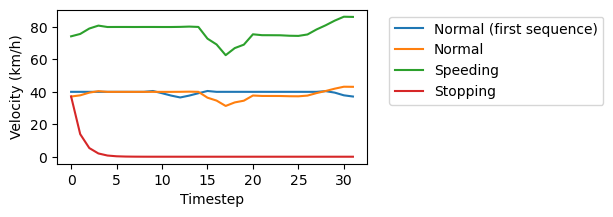

In [7]:
plt.figure(figsize=(4,2))
plt.plot(seq1.flatten(), label='Normal (first sequence)')
plt.plot(seq2_normal.flatten(), label='Normal')
plt.plot(seq2_speeding.flatten(), label='Speeding')
plt.plot(seq2_stopping.flatten(), label='Stopping')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Timestep')
plt.ylabel('Velocity (km/h)')
plt.show()

In [8]:
# From the velocity, we can integrate to get the position
x1_normal = np.cumsum(seq1, axis=1)
x2_normal = np.cumsum(seq2_normal, axis=1)
x2_speeding = np.cumsum(seq2_speeding, axis=1)
x2_stopping = np.cumsum(seq2_stopping, axis=1)
x2_reverse = -x2_normal
print('Shape of x1: ', x1_normal.shape)

Shape of x1:  (1, 32)


Text(0, 0.5, 'Position (m)')

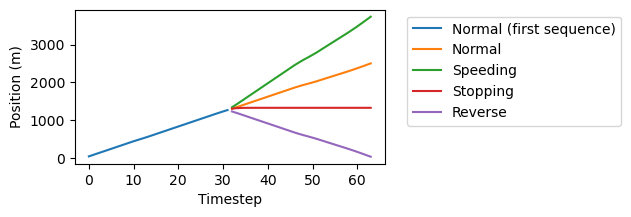

In [9]:
plt.figure(figsize=(4,2))
plt.plot(x1_normal.flatten(), label='Normal (first sequence)')
plt.plot(np.arange(0, 32) + 32, x2_normal.flatten() + x1_normal.flatten()[-1], label='Normal')
plt.plot(np.arange(0, 32) + 32, x2_speeding.flatten() + x1_normal.flatten()[-1], label='Speeding')
plt.plot(np.arange(0, 32) + 32, x2_stopping.flatten() + x1_normal.flatten()[-1], label='Stopping')
plt.plot(np.arange(0, 32) + 32, x2_reverse.flatten() + x1_normal.flatten()[-1], label='Reverse')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Timestep')
plt.ylabel('Position (m)')

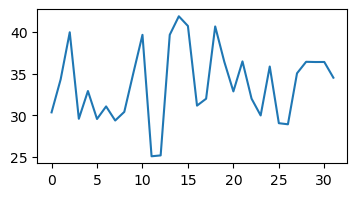

Predicted expected velocity: 33.735535


In [10]:
seq_pred = model.predict_sequence(seq1.reshape(1, 1, -1))
plt.figure(figsize=(4,2))
plt.plot(seq_pred.flatten())
plt.show()

print('Predicted expected velocity:', np.mean(seq_pred))
x2p = np.cumsum(seq_pred.flatten())

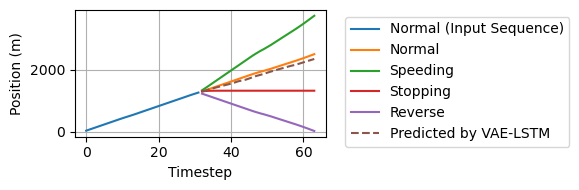

In [75]:
plt.figure(figsize=(6,2))
plt.plot(x1_normal.flatten(), label='Normal (Input Sequence)')
plt.plot(np.arange(0, 32) + 32, x2_normal.flatten() + x1_normal.flatten()[-1], label='Normal')
plt.plot(np.arange(0, 32) + 32, x2_speeding.flatten() + x1_normal.flatten()[-1], label='Speeding')
plt.plot(np.arange(0, 32) + 32, x2_stopping.flatten() + x1_normal.flatten()[-1], label='Stopping')
plt.plot(np.arange(0, 32) + 32, x2_reverse.flatten() + x1_normal.flatten()[-1], label='Reverse')
plt.plot(np.arange(0, 32) + 32, x2p + x1_normal.flatten()[-1], '--', label='Predicted by VAE-LSTM')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Timestep')
plt.ylabel('Position (m)')
plt.grid()
plt.tight_layout()

plt.savefig('vae_lstm_prediction.pdf', bbox_inches='tight')

In [76]:
# Plot the anomaly score
def compute_anomaly_score(pred_seq, observed_seq):
    d = np.sqrt(np.square(pred_seq.flatten() - observed_seq.flatten()))
    return np.cumsum(d)

a2_normal = compute_anomaly_score(x2p, x2_normal)
a2_speeding = compute_anomaly_score(x2p, x2_speeding)
a2_stopping = compute_anomaly_score(x2p, x2_stopping)
a2_reverse = compute_anomaly_score(x2p, x2_reverse)

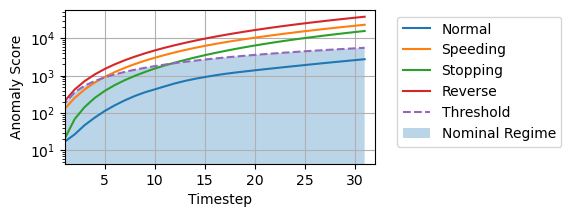

In [77]:
plt.figure(figsize=(4,2))
plt.plot(a2_normal, label='Normal')
plt.plot(a2_speeding, label='Speeding')
plt.plot(a2_stopping, label='Stopping')
plt.plot(a2_reverse, label='Reverse')

# Create and plot the threshold line
threshold = np.arange(-2,32) * 180.0
plt.plot(np.arange(-2,32), threshold, '--', label='Threshold')

# Fill the area between the threshold and x-axis
plt.fill_between(range(-2,32), threshold, alpha=0.3, label='Nominal Regime')

plt.yscale('log')  # Switch y-axis to logarithmic scale
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Timestep')
plt.ylabel('Anomaly Score')
plt.xlim((1, 32))
plt.grid()

plt.savefig('vae_lstm_anomaly_score.pdf', bbox_inches='tight')

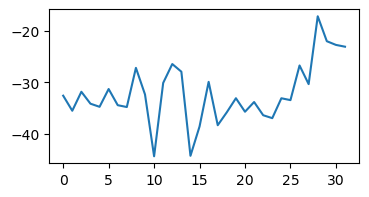

Predicted expected velocity: -32.148777


In [78]:
seq_pred_neg = model.predict_sequence((-seq1).reshape(1, 1, -1))
plt.figure(figsize=(4,2))
plt.plot(seq_pred_neg.flatten())
plt.show()

print('Predicted expected velocity:', np.mean(seq_pred_neg))
x2pn = np.cumsum(seq_pred_neg.flatten())

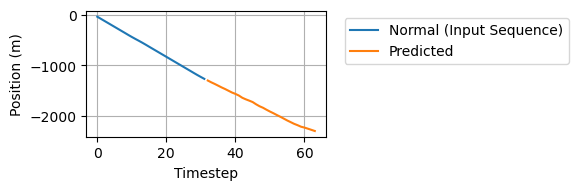

In [79]:
plt.figure(figsize=(6,2))
plt.plot(-x1_normal.flatten(), label='Normal (Input Sequence)')
plt.plot(np.arange(0, 32) + 32, x2pn.flatten() - x1_normal.flatten()[-1], label='Predicted')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Timestep')
plt.ylabel('Position (m)')
plt.grid()
plt.tight_layout()
plt.savefig('vae_lstm_prediction_negative.pdf', bbox_inches='tight')

In [80]:
a2_reverse_neg = compute_anomaly_score(x2pn, x2_reverse)

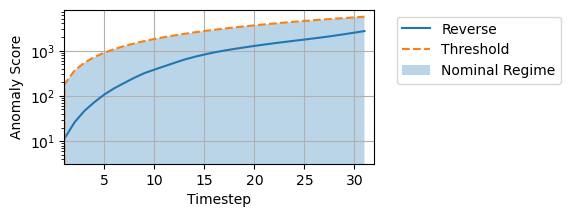

In [81]:
plt.figure(figsize=(4,2))
plt.plot(a2_reverse_neg, label='Reverse')

# Create and plot the threshold line
threshold = np.arange(-2,32) * 180.0
plt.plot(np.arange(-2,32), threshold, '--', label='Threshold')

# Fill the area between the threshold and x-axis
plt.fill_between(range(-2,32), threshold, alpha=0.3, label='Nominal Regime')

plt.yscale('log')  # Switch y-axis to logarithmic scale
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Timestep')
plt.ylabel('Anomaly Score')
plt.xlim((1, 32))
plt.grid()

plt.savefig('vae_lstm_anomaly_score_neg.pdf', bbox_inches='tight')